In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib
from xgboost import plot_importance
import matplotlib.pyplot as plt


In [2]:
# Training Data (CC undersampling)===Testing Data (CC undersampling)
train_df = pd.read_csv(".././Training-Testing Dataset/Training Data (RWS Oversampling).csv")
test_df = pd.read_csv(".././Training-Testing Dataset/Testing Data CC undersampling.csv")
# test_df = pd.read_csv(".././Training-Testing Dataset/Testing Data (CC undersampling).csv")

X_train = train_df.drop(columns=["target"])
Y_train = train_df["target"]
X_test = test_df.drop(columns=["target"])
Y_test = test_df["target"]


print(Y_train.value_counts())
print(Y_test.value_counts())


target
Medium_Yes    4492
Low_No        4492
Medium_No     4492
High_No       4492
Low_Yes       4492
High_Yes      4492
Name: count, dtype: int64
target
High_No       509
Low_No        509
Medium_Yes    509
Medium_No     509
High_Yes      304
Low_Yes       188
Name: count, dtype: int64


In [3]:
encoders = {}
target_col = "target"
for col in X_train.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.fit_transform(X_test[col].astype(str))
    encoders[col] = le

if Y_train.dtype == 'object' or str(Y_train.dtype) == 'category':
    le_target = LabelEncoder()
    Y_train = le_target.fit_transform(Y_train)
    Y_test = le_target.fit_transform(Y_test)
    encoders[target_col] = le_target


In [6]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  
    num_class=len(np.unique(Y_train)), 
    eval_metric='mlogloss',      
    use_label_encoder=False,
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=10,
    random_state=42
)

xgb_model.fit(X_train, Y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred)) ==used this 

c:\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:06:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7227

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       509
           1       0.87      0.98      0.92       304
           2       0.68      0.57      0.62       509
           3       0.84      1.00      0.91       188
           4       0.54      0.59      0.56       509
           5       0.91      0.97      0.94       509

    accuracy                           0.72      2528
   macro avg       0.74      0.77      0.75      2528
weighted avg       0.71      0.72      0.72      2528



In [7]:
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(encoders, "encoders.pkl")


Model and encoders saved successfully!


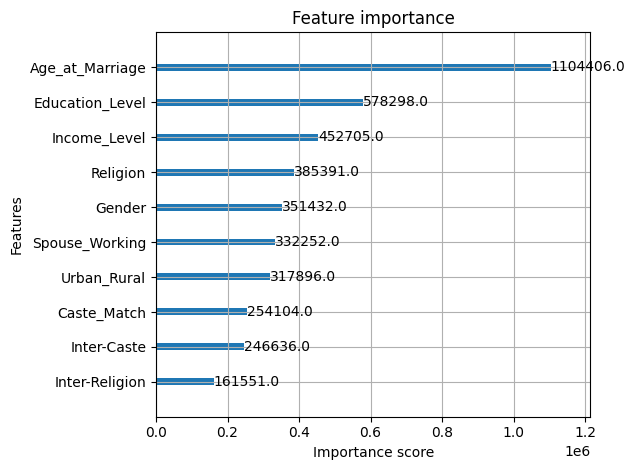

In [9]:

plot_importance(model, max_num_features=15)
plt.tight_layout()
plt.savefig("xgb_importance.png", dpi=300, bbox_inches="tight")
plt.show()

In [3]:
model = joblib.load(r"D:\FinalYearProject\Matrimony_Matchmaker\notebooks\Model-xgboost\xgb_model.pkl")

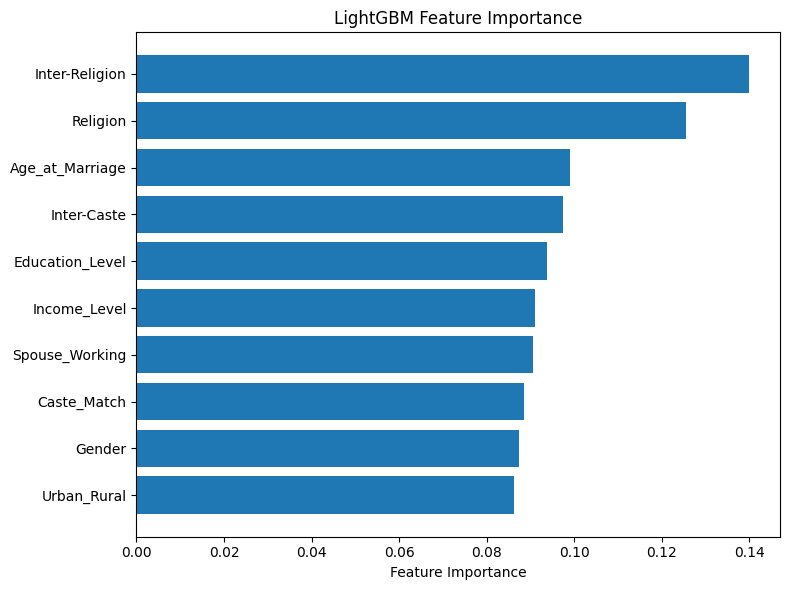

In [8]:
importances = model.feature_importances_
indices = np.argsort(importances)
feature_names = model.get_booster().feature_names
plt.figure(figsize=(8,6))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), np.array(feature_names)[indices])
plt.xlabel("Feature Importance")
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.savefig("LightGBM Feature Importance.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

encoders = joblib.load("encoders.pkl")

test_df_cc = pd.read_csv(".././Training-Testing Dataset/Testing data Undersampled(All).csv")
X_test_cc = test_df_cc.drop(columns=["target"])
Y_test_cc = test_df_cc["target"]

for col in X_test_cc.columns:
    if col in encoders and col != "target":
        le = encoders[col]
        X_test_cc[col] = X_test_cc[col].fillna("NA").astype(str)
        known_labels = set(le.classes_)
        X_test_cc[col] = X_test_cc[col].apply(lambda x: x if x in known_labels else "UNK")
        if "UNK" not in le.classes_:
            le.classes_ = np.append(le.classes_, "UNK")
        X_test_cc[col] = le.transform(X_test_cc[col])

le_target = encoders["target"]
Y_test_cc_encoded = le_target.transform(Y_test_cc.astype(str))

y_pred = model.predict(X_test_cc)

y_pred_decoded = le_target.inverse_transform(y_pred)

accuracy = accuracy_score(Y_test_cc_encoded, y_pred)
print(f"Accuracy rate: {accuracy*100:.2f}%\n")

print("Classification Report:")
print(classification_report(Y_test_cc_encoded, y_pred, target_names=le_target.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(Y_test_cc_encoded, y_pred))


Accuracy rate: 92.73%

Classification Report:
              precision    recall  f1-score   support

     High_No       0.92      0.85      0.88       188
    High_Yes       0.95      0.98      0.96       188
      Low_No       0.91      0.90      0.91       188
     Low_Yes       0.94      1.00      0.97       188
   Medium_No       0.88      0.85      0.86       188
  Medium_Yes       0.96      0.98      0.97       188

    accuracy                           0.93      1128
   macro avg       0.93      0.93      0.93      1128
weighted avg       0.93      0.93      0.93      1128


Confusion Matrix:
[[160   2   8   2  15   1]
 [  0 184   0   3   0   1]
 [  8   1 170   3   6   0]
 [  0   0   0 188   0   0]
 [  6   4   9   4 159   6]
 [  0   3   0   0   0 185]]


In [10]:
print(encoders)

{'Gender': LabelEncoder(), 'Education_Level': LabelEncoder(), 'Caste_Match': LabelEncoder(), 'Religion': LabelEncoder(), 'Urban_Rural': LabelEncoder(), 'Income_Level': LabelEncoder(), 'Spouse_Working': LabelEncoder(), 'Inter-Caste': LabelEncoder(), 'Inter-Religion': LabelEncoder(), 'target': LabelEncoder()}
